In [3]:
import sys
!{sys.executable} -m pip install -r requirements.txt
!{sys.executable} -m pip install --upgrade git+https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git 
!{sys.executable} -m pip install --upgrade git+https://github.com/hms-dbmi/pic-sure-python-client.git 

In [5]:
import seaborn as sns

In [6]:
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import PicSureHpdsLib
import PicSureClient

from python_lib.utils import get_multiIndex_variablesDict, joining_variablesDict_onCol
from python_lib.HPDS_connection_manager import tokenManager

In [7]:
# Pandas DataFrame display options
pd.set_option("max.rows", 435)

# Matplotlib display parameters
plt.rcParams["figure.figsize"] = (14,8)
font = {'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)

In [8]:
PICSURE_network_URL = "https://biodatacatalyst.integration.hms.harvard.edu/picsure"
resource_id = "02e23f52-f354-4e8b-992c-d37c8b9ba140"
token_file = "token.txt"

In [9]:
with open(token_file, "r") as f:
    token = f.read()

In [10]:
client = PicSureClient.Client()
connection = client.connect(PICSURE_network_URL, token)
adapter = PicSureHpdsLib.Adapter(connection)
resource = adapter.useResource(resource_id)

## Get studies information

In [11]:
from ast import literal_eval
studies_info = pd.read_csv("../studies_info.csv",
                           index_col=0, 
                          converters={"phs_list": literal_eval})

## Get individual studies statistics

In [12]:
plain_variablesDict = resource.dictionary().find().DataFrame()
variablesDict = get_multiIndex_variablesDict(plain_variablesDict)

In [13]:
mask_consent_var = plain_variablesDict.index.str.contains("Study Accession with Consent Code")
consent_var = plain_variablesDict.index[mask_consent_var].values[0]

In [14]:
#for phs in phs_index:
def get_one_study(phs: str,
                    studies_info: pd.DataFrame,
                    consent_var: str,
                    variablesDict: pd.DataFrame,
                    resource, 
                 **kwargs) -> pd.DataFrame:
    phs_list = studies_info.loc[phs, "phs_list"]
    bdc_study_name = studies_info.loc[phs, "BDC_study_name"]
    selected_var = variablesDict.loc[bdc_study_name, "varName"].values.tolist()
    query = resource.query()
    query.filter().add(consent_var, phs_list)
    query.select().add(key=selected_var)
    facts = query.getResultsDataFrame(**kwargs)
    return facts

In [15]:
phs = studies_info.index[1]

In [16]:
facts = get_one_study(phs, 
                      studies_info, 
                      consent_var, 
                      variablesDict, 
                      resource,
                     low_memory=False)

In [17]:
facts.shape

(10385, 343)

## Matplotlib palettes

In [16]:
import sys
!{sys.executable} -m pip install colorspacious

In [17]:
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict

cmaps = OrderedDict()

In [18]:
cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']

In [19]:
cmaps["Qualitative"][6]

'Set2'

# Describe the study

## BASIC STATISTICS

In [24]:
print("Number of subjects: {0}\nNumber of variables: {1}".format(*facts.shape))

Number of subjects: 10385
Number of variables: 343


# Variable types description

In [51]:
var_dtypes = facts.dtypes.value_counts()
#eav_dic["var_dtypes"] = var_dtypes.to_dict()

Text(0.5, 1.0, 'Variable count per variable type')

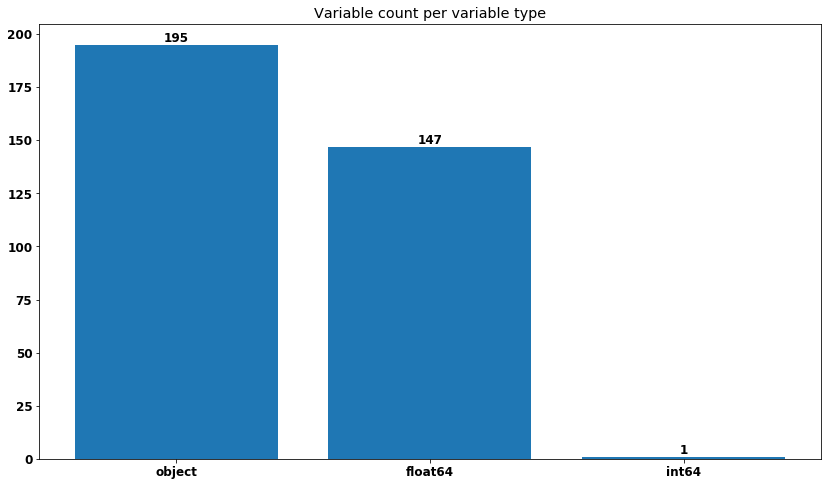

In [66]:
fig, ax = plt.subplots()
plt.bar(x=var_dtypes.index.astype("str").tolist(), height=var_dtypes.values.tolist())
for x, y in enumerate(var_dtypes):
    ax.text(x, y, y, ha="center", va="bottom")
ax.set_title("Variable count per variable type")

### Number of subjects (non-null values) per variable type

In [29]:
num = num_describe.loc["count",:].to_frame().assign(dtype="numerical")
categorical = categorical_describe.loc["count",:].to_frame().assign(dtype="categorical")
long_df = pd.concat([num, categorical], axis=0).astype({"count": int})

Text(0.5, 1.0, 'Variable count per dtype')

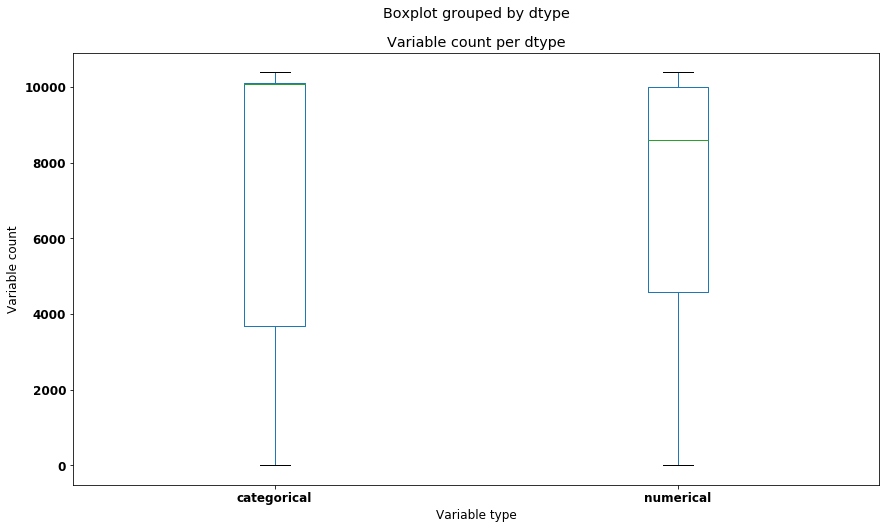

In [75]:
ax = long_df.boxplot(column = "count", by="dtype", grid=False)
ax.set_xlabel("Variable type")
ax.set_ylabel("Variable count")
ax.set_title("Variable count per dtype")

Text(0.5, 0.98, 'Variable count per variable type')

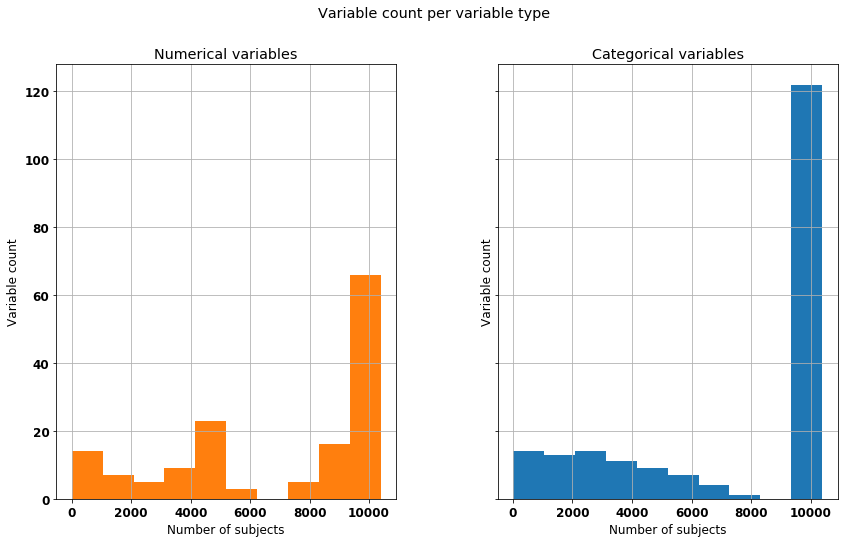

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
long_df.loc[long_df["dtype"] == "numerical",:].hist("count", color="tab:orange", ax=ax1)
ax1.set_title("Numerical variables")
long_df.loc[long_df["dtype"] == "categorical",:].hist("count", color="tab:blue", ax=ax2)
ax2.set_title("Categorical variables")
x_label = "Number of subjects"
y_label = "Variable count"
ax1.set_xlabel(x_label), ax2.set_xlabel(x_label)
ax1.set_ylabel(y_label), ax2.set_ylabel(y_label)
fig.suptitle("Number of subjects per variable type")

## CATEGORICAL VARIABLES DESCRIPTION

In [25]:
categorical_describe = facts.describe(include=['object'])
categorical_describe

,\Genetic Epidemiology of COPD (COPDGene)\Samples\Sample ID used in the Source Repository\,\Genetic Epidemiology of COPD (COPDGene)\Samples\Source repository where samples originate\,\Genetic Epidemiology of COPD (COPDGene)\Samples\Subject ID\,\Genetic Epidemiology of COPD (COPDGene)\Subject Images\De-identified subject ID\,\Genetic Epidemiology of COPD (COPDGene)\Subject Images\Folder name of subject image\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Six minute walk: course layout\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Six minute walk: was your walking limited?\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Walk symptoms: back pain\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Walk symptoms: joint pain\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Walk symptoms: leg discomfort/fatigue\,...,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Sociodemography and Administration\Race Adjusted\Dbgap_id\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Sociodemography and Administration\Race Adjusted\De-identified site code\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Spirometry\Postbronchodilator Pulmonary Function Testing\PFT\PFT used: pre post failed noUtah\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\TLC\Flag for low TLC percent predicted (<70%)\,\Genetic Epidemiology of COPD (COPDGene)\Subjects\Affection status\,\Genetic Epidemiology of COPD (COPDGene)\Subjects\Consent group as determined by DAC\,\Genetic Epidemiology of COPD (COPDGene)\Subjects\De-identified subject ID\,\Genetic Epidemiology of COPD (COPDGene)\Subjects\Source repository where subjects originate\,\Genetic Epidemiology of COPD (COPDGene)\Subjects\Subject ID used in the Source Repository\,\_Consents\Short Study Accession with Consent Code\
count,12,12,10003,2401,2401,10090,10090,3688,3688,3688,...,10371,10371,10099,10099,10371,10383,10383,12,12,10385
unique,12,1,10003,2401,2401,2,2,2,2,2,...,10371,21,3,2,4,3,10383,1,12,3
top,NA18500,Coriell,COPDGene_S42135,COPDGene_R51892,COPDGene_J54297.tar.gz,Straight,No,No,No,No,...,COPDGene_S42135,C09,post,Not flagged as an issue,Control,Health/Medical/Biomedical (HMB),COPDGene_S42135,Coriell,NA18500,phs000179.c1
freq,1,12,1,1,1,9614,6372,2903,2801,1942,...,1,1381,10014,9495,4499,10099,1,12,1,10101


In [26]:
mask_id = categorical_describe.loc["freq",:] != 1
categorical_describe.loc[:, mask_id]

,\Genetic Epidemiology of COPD (COPDGene)\Samples\Source repository where samples originate\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Six minute walk: course layout\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Six minute walk: was your walking limited?\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Walk symptoms: back pain\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Walk symptoms: joint pain\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Walk symptoms: leg discomfort/fatigue\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Walk symptoms: shortness of breath\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\CT Acquisition Parameters\CT Scanner\CT scan final approval\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\CT Assessment Scoresheet\High Concerns\QA_CalciumCalPad\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Demographics and Physical Characteristics\Demographics\Gender\,...,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Respiratory Disease\Respiratory Symptoms\Wheezing or Whistling in Chest\Wheezing: when you have a cold\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Respiratory Disease\Severity of COPD Exacerbations\Chest Trouble\Been treated with steroid pills or injections\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Respiratory Disease\Severity of COPD Exacerbations\Chest Trouble\Had a flare-up of chest troubles in last 12 months\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Sociodemography and Administration\Race Adjusted\De-identified site code\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Spirometry\Postbronchodilator Pulmonary Function Testing\PFT\PFT used: pre post failed noUtah\,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\TLC\Flag for low TLC percent predicted (<70%)\,\Genetic Epidemiology of COPD (COPDGene)\Subjects\Affection status\,\Genetic Epidemiology of COPD (COPDGene)\Subjects\Consent group as determined by DAC\,\Genetic Epidemiology of COPD (COPDGene)\Subjects\Source repository where subjects originate\,\_Consents\Short Study Accession with Consent Code\
count,12,10090,10090,3688,3688,3688,3688,9865,7673,10099,...,4779,10098,10099,10371,10099,10099,10371,10383,12,10385
unique,1,2,2,2,2,2,2,2,3,2,...,2,2,2,21,3,2,4,3,1,3
top,Coriell,Straight,No,No,No,No,Checked (multiple-response),Yes,No,Male,...,Yes,No,No,C09,post,Not flagged as an issue,Control,Health/Medical/Biomedical (HMB),Coriell,phs000179.c1
freq,12,9614,6372,2903,2801,1942,2445,9549,4288,5374,...,3561,8442,7516,1381,10014,9495,4499,10099,12,10101


### Number of modalities

In [43]:
max_nonnull = long_df["count"].max()
mask_categorical = facts.dtypes == "object"
number_modalities = facts.loc[:, mask_categorical].apply(lambda x: x.unique().shape[0])
filter_max_cat = max_nonnull*0.2
mask_modalities = number_modalities.between(2, filter_max_cat)

Text(0.5, 0, 'Number of modalities')

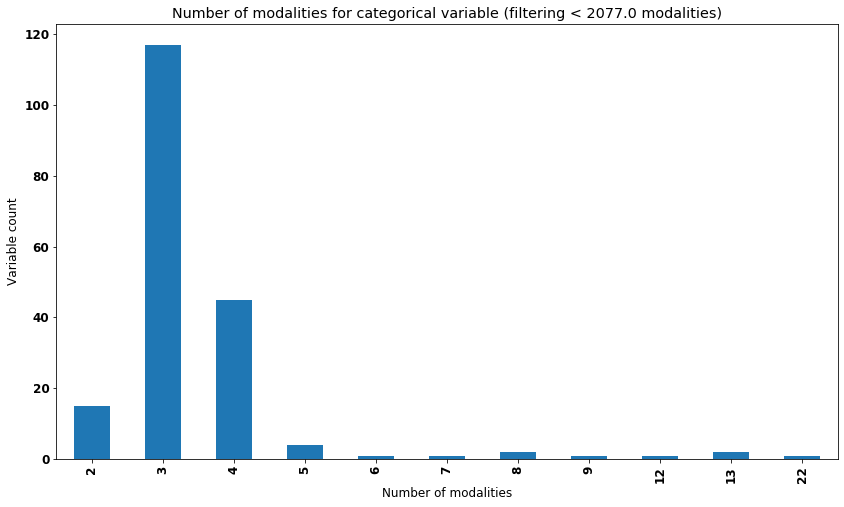

In [49]:
ax = number_modalities[mask_modalities].value_counts().sort_index().plot(kind="bar")
ax.set_title("Number of modalities for categorical variable (filtering < {0} modalities)".format(filter_max_cat.round(0)))
ax.set_ylabel("Variable count")
ax.set_xlabel("Number of modalities")

### NUMERICAL VARIABLES DESCRIPTION

In [26]:
numerical_describe = facts.describe(include=["float", "int"]).transpose()
numerical_describe

,count,mean,std,min,25%,50%,75%,max
Patient ID,10385.0,40647.869620,5534.010311,35404.000000,38000.000000,40596.00000,43192.000000,507518.00000
\Genetic Epidemiology of COPD (COPDGene)\Samples\Sample ID\,411.0,4502.508516,1509.677503,3004.000000,3118.500000,3886.00000,6358.500000,7258.00000
\Genetic Epidemiology of COPD (COPDGene)\Samples\Sample Use\,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
\Genetic Epidemiology of COPD (COPDGene)\Samples\Study\,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Distance walked [ft]\,9958.0,1349.850874,400.373369,1.000000,1110.000000,1378.00000,1620.000000,2690.00000
\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Supplemental O2 used during 6-min walk L/min\,10089.0,0.255823,1.034339,0.000000,0.000000,0.00000,0.000000,15.00000
\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\CT Acquisition Parameters\CT Scanner\CT scanner\,10.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\CT Acquisition Parameters\CT Scanner\Siemens sensation-64 flag\,9865.0,0.164622,0.370858,0.000000,0.000000,0.00000,0.000000,1.00000
\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\CT Acquisition Parameters\CT Slicer\Exp Mean Atten / Insp Mean Atten ratio CT Slicer\,8276.0,0.867462,0.064973,0.636600,0.821300,0.86735,0.918400,1.10920
\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\CT Acquisition Parameters\CT Slicer\FRC CT Slicer\,8276.0,3.235018,1.134715,1.008900,2.429450,3.00480,3.775775,8.99550


# Quality checking / data filtering

Discarding data that did show the subsequent criteria:
- Using variable name:
    - Filtering variables which names includes: ["ID", "identifiant"]
- Using variable distribution: 
    - No non-null values
    - Only 1 unique value (ie every non-null values identical)

Transforming data type:
- Numerical data that only posess 2-3 distinct integer values: recoded as categorical
- 

In [37]:
var = np.NaN
var.is_integer()

False

In [42]:
mask = facts.dtypes == "int"
facts.loc[:, mask]

,Patient ID
0,35404
1,35405
2,35406
3,35407
4,35408
...,...
10380,45784
10381,45785
10382,45786
10383,122723
